In [1]:
import pandas as pd
import numpy as np
import datetime
import collections
import matplotlib.pyplot as plot
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.api as stat
import math
from sklearn.model_selection import train_test_split
import statsmodels.api as stat
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection


### Data
- `const`: Constant:  needed for regression
- `Barangay`: Barangay name
- `Date`: Month and year
- `Age`: Average age:  taken from QC census 2015
- `Address`: Number of cases
- `DenWarn`: Number of cases with warning signs 
- `DenNoWarn`: Number of cases with no warning signs 
- `DenSev`: Number of cases of severe dengue 
- `HemWarn`: Number of cases with hemmorhaging and warning signs
- `HemNoWarn`: Number of cases with hemmorhaging and no warning signs
- `HemSev`: Number of cases with hemmorhaging and severe dengue
- `Month`: Month
- `Year`: Year
- `NDWI`: Measure of water density
- `FAPAR`: Measure of vegetation
- `lon`: Longitude
- `lat`: Latitude
- `ALICIA`: Dummy variable for barangay (Applies to all barangays)
- `Binary`: Binary for whether there was at least 1 case in the given month for the barangay
- `medRisk`: Binary for whether there were at least 5 cases in the given month for the barangay
- `highRisk`: Binary for whether there were at least 20 cases in the given month for the barangay
- `M1`: Dummary variable for month (Applies to all months)


In [2]:
philhealthSummary = pd.read_csv("philhealthSummary.csv")

In [3]:
philhealthSummary

,Unnamed: 0,index,Barangay,Date,Age,Address,DenWarn,DenNoWarn,DenSev,HemWarn,...,WEST TRIANGLE,WHITE PLAINS,Binary,medRisk,highRisk,Name,City,Area,Density,Pop
0,0,0,ALICIA,2016-01,16.000000,1,0,0,1,0,...,0,0,1,0,0,ALICIA,Quezon City,0.11,58287.19,6411.5909
1,1,1,ALICIA,2016-02,15.000000,1,0,0,1,0,...,0,0,1,0,0,ALICIA,Quezon City,0.11,58287.19,6411.5909
2,2,2,ALICIA,2016-03,13.000000,1,0,0,1,0,...,0,0,1,0,0,ALICIA,Quezon City,0.11,58287.19,6411.5909
3,3,3,ALICIA,2016-06,16.000000,1,0,0,1,0,...,0,0,1,0,0,ALICIA,Quezon City,0.11,58287.19,6411.5909
4,4,4,ALICIA,2016-07,15.000000,4,0,0,2,2,...,0,0,1,0,0,ALICIA,Quezon City,0.11,58287.19,6411.5909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4820,4820,875,WHITE PLAINS,2017-5,36.685539,0,0,0,0,0,...,0,1,0,0,0,WHITE PLAINS,Quezon City,0.57,8296.97,4729.2729
4821,4821,876,WHITE PLAINS,2017-10,36.685539,0,0,0,0,0,...,0,1,0,0,0,WHITE PLAINS,Quezon City,0.57,8296.97,4729.2729
4822,4822,877,WHITE PLAINS,2018-4,36.685539,0,0,0,0,0,...,0,1,0,0,0,WHITE PLAINS,Quezon City,0.57,8296.97,4729.2729
4823,4823,878,WHITE PLAINS,2018-5,36.685539,0,0,0,0,0,...,0,1,0,0,0,WHITE PLAINS,Quezon City,0.57,8296.97,4729.2729


### Data Exploration

#### Dengue by month
Not all barangays experience an increase in cases during the rainy months (shown by how there are still barangays with 0 cases during June to Dec), but there is a visible peak among others

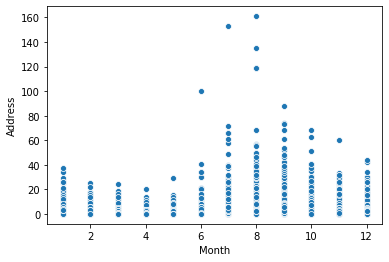

In [4]:
sns.scatterplot(philhealthSummary['Month'],
                philhealthSummary['Address'])

#### Dengue by water density and vegetation
It appears that FAPAR and NDWI have no strong positive relationship with number of dengue cases unlike we expected – it's either that (1) the data was incorrectly sampled which is likely with different computation and missing images, or (2) there are other characteristics of barangays that make them more prone to dengue, outside of water (poverty, low immunity, mean age)

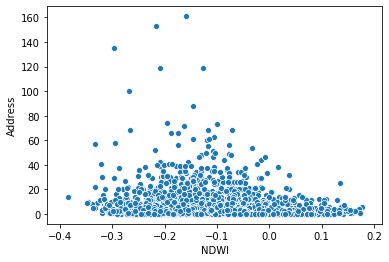

In [28]:
sns.scatterplot(philhealthSummary['NDWI'],
                philhealthSummary['Address'])

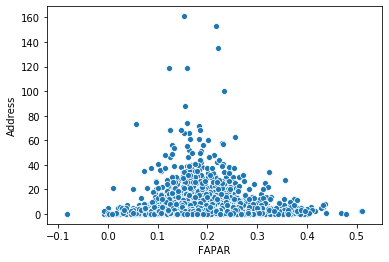

In [29]:
sns.scatterplot(philhealthSummary['FAPAR'],
                philhealthSummary['Address'])

#### Doubtful/Bad NDWI and FAPAR data
NDWI and FAPAR do not correlate with the rainy months, but at the same time not sure how well NDWI and FAPAR are captured in a city (water flows away faster with the concrete)?

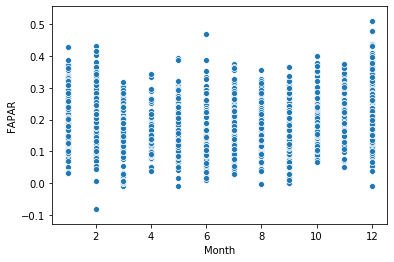

In [30]:
sns.scatterplot(philhealthSummary['Month'],
                philhealthSummary['FAPAR'])

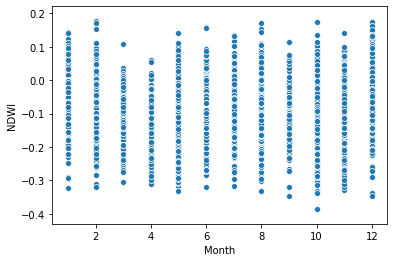

In [31]:
sns.scatterplot(philhealthSummary['Month'],
                philhealthSummary['NDWI'])

#### Dengue by barangay
Seems that poorer barangays are prone to high cases of dengue, maybe poor living conditions where mosquitos can breed would be a good indicator of dengue

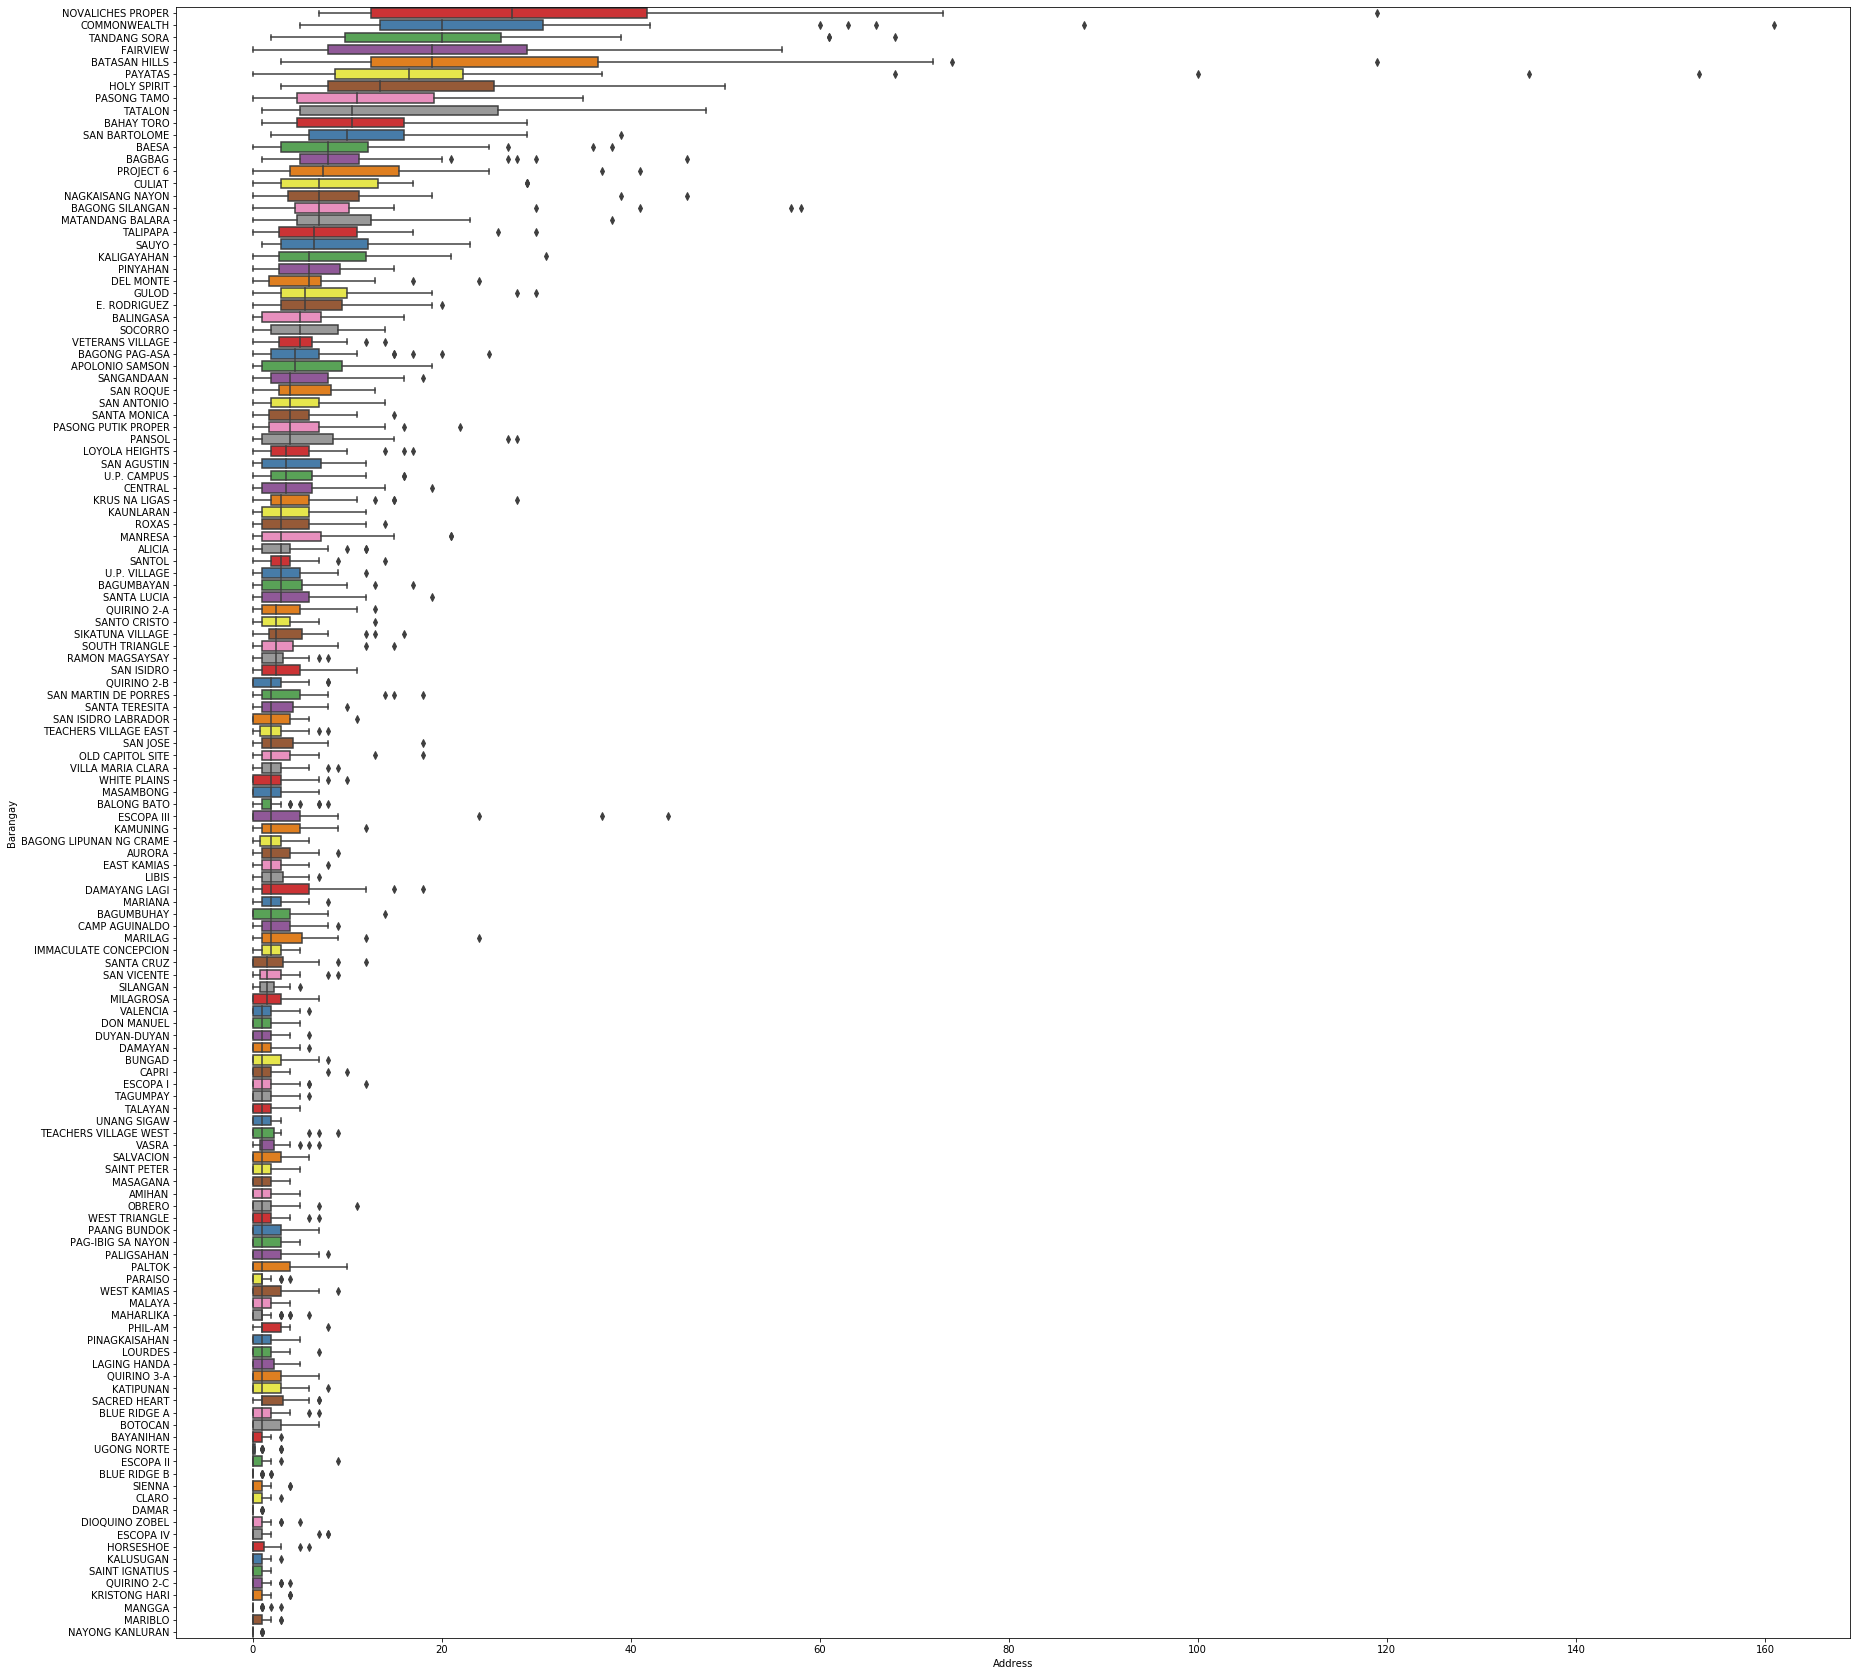

In [32]:
#sorted(, reverse=True)
median = pd.DataFrame(philhealthSummary.groupby(by=['Barangay'])['Address'].median())
median = median.sort_values(by='Address',ascending=False)
median = median.index

fig, ax = plot.subplots(figsize=(30,30))
sns.boxplot(ax=ax, y='Barangay', x='Address', 
            data=philhealthSummary, palette="Set1", 
            order=median, orient='h')



* So where are Payatas, Tandang Sora, Novaliches Proper, and Commonwealth?

In [39]:
philhealthSummary['Risk'] = 1*(philhealthSummary['TANDANG SORA']+
                               philhealthSummary['NOVALICHES PROPER']+
                               philhealthSummary['PAYATAS']+
                               philhealthSummary['COMMONWEALTH']>0)

#### Dengue by age
Age is a strong predictor for dengue cases, which coincides with how dengue affects younger people, and so naturally barangays with lower ages are more prone

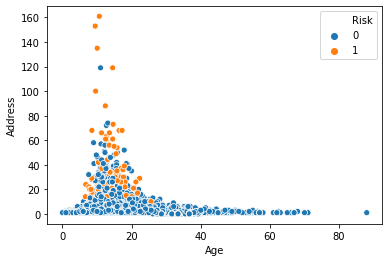

In [40]:
sns.scatterplot(philhealthSummary['Age'],
                philhealthSummary['Address'],
                hue=philhealthSummary['Risk'])

#### Dengue by density
* Appears to peak initially but fluctuates, no apparent linear trend

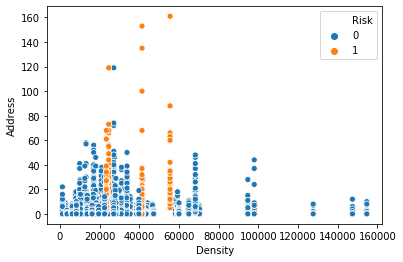

In [38]:
sns.scatterplot(philhealthSummary['Density'],
                philhealthSummary['Address'],
                hue=philhealthSummary['Risk'])

### Prediction
#### Predict if a barangay will have dengue
- Classification as `at risk` (i.e. we predict there will be at least one case) or `no risk` (none)
- Ideally we want to predict dengue solely based on the month, water & vegetation - and have it predict if a place will have dengue regardless of barangay
- However we see it only reaches 63% maximum accuracy on the test set

In [21]:
pop = pd.read_csv('/Users/lorenzoflores/Desktop/Nerve/Online Class/Pop_HumDataExchange.csv')

In [22]:
qc_pop = pop.loc[pop.adm3_name=='Quezon City']

In [24]:
qc_pop.reset_index(drop=True, inplace=True)

In [26]:
qc_pop['adm4_name'] = [item.upper() for item in qc_pop.adm4_name]

/Users/lorenzoflores/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
set(qc_pop.adm4_name).difference(set(philhealthSummary.Barangay))

{'DOÑA IMELDA',
 'DOÑA JOSEFA',
 'GREATER LAGRO',
 'N.S. AMORANTO (GINTONG SILAHIS)',
 'NEW ERA (CONSTITUTION HILLS)',
 'NORTH FAIRVIEW',
 'PASONG PUTIK PROPER (PASONG PUTIK)',
 'SANTO DOMINGO (MATALAHIB)',
 'SANTO NIÑO'}

In [28]:
set(philhealthSummary.Barangay).difference(set(qc_pop.adm4_name))

{'PASONG PUTIK PROPER'}

In [17]:
set(philhealthSummary.Barangay)

{'ALICIA',
 'AMIHAN',
 'APOLONIO SAMSON',
 'AURORA',
 'BAESA',
 'BAGBAG',
 'BAGONG LIPUNAN NG CRAME',
 'BAGONG PAG-ASA',
 'BAGONG SILANGAN',
 'BAGUMBAYAN',
 'BAGUMBUHAY',
 'BAHAY TORO',
 'BALINGASA',
 'BALONG BATO',
 'BATASAN HILLS',
 'BAYANIHAN',
 'BLUE RIDGE A',
 'BLUE RIDGE B',
 'BOTOCAN',
 'BUNGAD',
 'CAMP AGUINALDO',
 'CAPRI',
 'CENTRAL',
 'CLARO',
 'COMMONWEALTH',
 'CULIAT',
 'DAMAR',
 'DAMAYAN',
 'DAMAYANG LAGI',
 'DEL MONTE',
 'DIOQUINO ZOBEL',
 'DON MANUEL',
 'DUYAN-DUYAN',
 'E. RODRIGUEZ',
 'EAST KAMIAS',
 'ESCOPA I',
 'ESCOPA II',
 'ESCOPA III',
 'ESCOPA IV',
 'FAIRVIEW',
 'GULOD',
 'HOLY SPIRIT',
 'HORSESHOE',
 'IMMACULATE CONCEPCION',
 'KALIGAYAHAN',
 'KALUSUGAN',
 'KAMUNING',
 'KATIPUNAN',
 'KAUNLARAN',
 'KRISTONG HARI',
 'KRUS NA LIGAS',
 'LAGING HANDA',
 'LIBIS',
 'LOURDES',
 'LOYOLA HEIGHTS',
 'MAHARLIKA',
 'MALAYA',
 'MANGGA',
 'MANRESA',
 'MARIANA',
 'MARIBLO',
 'MARILAG',
 'MASAGANA',
 'MASAMBONG',
 'MATANDANG BALARA',
 'MILAGROSA',
 'NAGKAISANG NAYON',
 'NAYONG KAN

In [224]:
X = philhealthSummary[['NDWI','FAPAR','Pop','M1','M2','M3','M4','M5','M6','M7','M8','M9','M10','M11','M12']]
y = philhealthSummary['Binary']


In [225]:
import warnings
warnings.filterwarnings('ignore') 

lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')

for i in np.arange(0,1,0.05):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    lr.fit(X_train, y_train)
    print(str(i)+": "+str(sum(1*([item[1] for item in lr.predict_proba(X_test)]>i) == y_test)/len(y_test)))


0.0: 0.5569739952718676
0.05: 0.5645390070921986
0.1: 0.5645390070921986
0.15000000000000002: 0.5588652482269504
0.2: 0.5711583924349882
0.25: 0.56548463356974
0.30000000000000004: 0.566903073286052
0.35000000000000003: 0.5626477541371159
0.4: 0.5673758865248227
0.45: 0.5758865248226951
0.5: 0.5621749408983452
0.55: 0.5040189125295508
0.6000000000000001: 0.4628841607565012
0.65: 0.40756501182033095
0.7000000000000001: 0.4260047281323877
0.75: 0.41702127659574467
0.8: 0.4326241134751773
0.8500000000000001: 0.4009456264775414
0.9: 0.44633569739952716
0.9500000000000001: 0.43451536643026006


- We see that the accuracy gets much better when age is included

In [113]:
X = philhealthSummary[['NDWI','FAPAR','Density','Age','M1','M2','M3','M4','M5','M6','M7','M8','M9','M10','M11','M12']]

lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')

for i in np.arange(0,1,0.05):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    lr.fit(X_train, y_train)
    print(str(i)+": "+str(sum(1*([item[1] for item in lr.predict_proba(X_test)]>i) == y_test)/len(y_test)))


0.0: 0.5617021276595745
0.05: 0.5858156028368794
0.1: 0.6524822695035462
0.15000000000000002: 0.557919621749409
0.2: 0.5754137115839244
0.25: 0.5735224586288417
0.30000000000000004: 0.8515366430260047
0.35000000000000003: 0.857210401891253
0.4: 0.8851063829787233
0.45: 0.7191489361702128
0.5: 0.9304964539007092
0.55: 0.4723404255319149
0.6000000000000001: 0.44160756501182036
0.65: 0.4335697399527187
0.7000000000000001: 0.4264775413711584
0.75: 0.8936170212765957
0.8: 0.4477541371158392
0.8500000000000001: 0.44964539007092197
0.9: 0.4132387706855792
0.9500000000000001: 0.42884160756501183


#### Predict number of dengue cases
- Nearly all the terms are significant but likely due to high variance and few number of parameters
- Notice a MSE of 81 (on average about 9 cases off, pretty high error)

In [210]:
import re
noZero = philhealthSummary[philhealthSummary['Binary']==1]
for i in range(19,160):
    if (' ' in noZero.columns[i]) or ('-' in noZero.columns[i]) or ('.' in noZero.columns[i]):
        x = re.sub(' ','_',noZero.columns[i])
        x = re.sub('-','_',x)
        x = re.sub('\.','',x)
        noZero = noZero.rename(columns={noZero.columns[i]: x})
brgyNames = ' + '.join(noZero.columns[19:160])

In [211]:
noZero['Age2'] = [item*item for item in noZero['Age']]
noZero['Month2'] = [item*item for item in noZero['Month']]
noZero = stat.add_constant(noZero)


In [222]:
results = sm.ols('Address ~ NDWI+FAPAR+Age+Age2+Month+Month2+Pop+'+brgyNames, data=noZero).fit()


In [223]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Address   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     16.91
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          3.50e-293
Time:                        16:54:29   Log-Likelihood:                -12491.
No. Observations:                3652   AIC:                         2.526e+04
Df Residuals:                    3512   BIC:                         2.613e+04
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -5.7555      0.922     -6.245      0.000      -7.563      -3.949
NDWI                       -0.3655      2.672     -0.137      0.891      -5.604       4.873
FAPAR                       6.2502      2.892      2.162      0.031       0.581      11.919
Age                         0.1076      0.037      2.939      0.003       0.036       0.179
Age2                       -0.0025      0.001     -3.605      0.000      -0.004      -0.001
Month                       1.5975      0.172      9.286      0.000       1.260       1.935
Month2                     -0.0869      0.013     -6.707      0.000      -0.112      -0.062
Pop                         0.0001    4.6e-06     31.250      0.000       0.000       0.000
ALICIA                      0.6659      1.353      0.492      0.623      -1.988       3.320
AMIHAN                     -0.6296      1.505     -0.418      0.676      -3.581       2.322
APOLONIO_SAMSON            -1.3629      1.325     -1.029      0.304      -3.960       1.234
AURORA                      0.3416      1.369      0.250      0.803      -2.342       3.025
BAESA                       0.1504      1.315      0.114      0.909      -2.427       2.728
BAGBAG                     -0.2663      1.232     -0.216      0.829      -2.681       2.148
BAGONG_LIPUNAN_NG_CRAME    -1.7340      1.448     -1.197      0.231      -4.574       1.106
BAGONG_PAG_ASA             -0.1905      1.302     -0.146      0.884      -2.744       2.363
BAGONG_SILANGAN            -3.4143      1.328     -2.572      0.010      -6.017      -0.811
BAGUMBAYAN                  0.3362      1.333      0.252      0.801      -2.277       2.949
BAGUMBUHAY                  0.6454      1.536      0.420      0.674      -2.367       3.658
BAHAY_TORO                 -1.5135      1.255     -1.206      0.228      -3.973       0.946
BALINGASA                   0.0534      1.284      0.042      0.967      -2.463       2.570
BALONG_BATO                -0.8165      1.353     -0.604      0.546      -3.469       1.836
BATASAN_HILLS               2.3020      1.168      1.970      0.049       0.011       4.593
BAYANIHAN                  -1.3702      1.877     -0.730      0.465      -5.050       2.310
BLUE_RIDGE_A               -0.0577      1.475     -0.039      0.969      -2.951       2.835
BLUE_RIDGE_B               -0.8790      2.657     -0.331      0.741      -6.089       4.331
BOTOCAN                    -0.2576      1.575     -0.164      0.870      -3.345       2.830
BUNGAD                     -0.2451      1.612     -0.152      0.879      -3.407       2.916
CAMP_AGUINALDO              0.0394      1.451      0.027      0.978      -2.805       2.884
CAPRI                      -1.8585      1.654     -1.123      0.261      -5.102       1.385
CENTRAL                     0.8185      1.375  

In [221]:
math.sqrt(sum([item*item for item in list((results.predict(noZero)-noZero['Address']))])/len(noZero['Address']))

7.400205808823776

* Upon controlling for the barangays, the RMSE is slightly reduced to 7

In [85]:
results = sm.ols('Address ~ NDWI+FAPAR+Age+Age2+M1+M2+M3+M4+M5+M6+M7+M8+M9+M10+M11+M12+'+brgyNames, data=noZero).fit()
    

In [87]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Address   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     17.41
Date:                Thu, 16 Apr 2020   Prob (F-statistic):               0.00
Time:                        09:12:42   Log-Likelihood:                -13267.
No. Observations:                3859   AIC:                         2.685e+04
Df Residuals:                    3703   BIC:                         2.782e+04
Df Model:                         155                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.6555      0.684      3.883      0.000       1.315       3.996
NDWI                       -5.6550      2.708     -2.088      0.037     -10.965      -0.345
FAPAR                       2.2477      2.897      0.776      0.438      -3.432       7.927
Age                         0.0688      0.036      1.899      0.058      -0.002       0.140
Age2                       -0.0015      0.001     -2.252      0.024      -0.003      -0.000
M1                         -0.5166      0.444     -1.165      0.244      -1.386       0.353
M2                         -1.9273      0.445     -4.330      0.000      -2.800      -1.055
M3                         -2.7158      0.463     -5.872      0.000      -3.623      -1.809
M4                         -4.3096      0.527     -8.181      0.000      -5.342      -3.277
M5                         -3.6512      0.512     -7.132      0.000      -4.655      -2.647
M6                         -1.0956      0.456     -2.404      0.016      -1.989      -0.202
M7                          2.5282      0.385      6.561      0.000       1.773       3.284
M8                          6.0242      0.376     16.043      0.000       5.288       6.760
M9                          4.1124      0.380     10.810      0.000       3.366       4.858
M10                         2.5884      0.399      6.491      0.000       1.807       3.370
M11                         1.3407      0.398      3.368      0.001       0.560       2.121
M12                         0.2777      0.417      0.666      0.505      -0.540       1.095
ALICIA                     -1.0949      1.381     -0.793      0.428      -3.802       1.612
AMIHAN                     -2.9416      1.536     -1.915      0.056      -5.953       0.070
APOLONIO_SAMSON             1.8782      1.346      1.396      0.163      -0.760       4.517
AURORA                     -1.5538      1.400     -1.110      0.267      -4.299       1.191
BAESA                       6.3816      1.339      4.766      0.000       3.756       9.007
BAGBAG                      5.1898      1.271      4.084      0.000       2.698       7.682
BAGONG_LIPUNAN_NG_CRAME    -2.4139      1.476     -1.635      0.102      -5.308       0.480
BAGONG_PAGASA               2.3159      1.325      1.748      0.081      -0.282       4.913
BAGONG_SILANGAN             5.9191      1.443      4.102      0.000       3.090       8.748
BAGUMBAYAN                 -0.2616      1.359     -0.193      0.847      -2.925       2.402
BAGUMBUHAY                 -2.0200      1.568     -1.288      0.198      -5.094       1.054
BAHAY_TORO                  6.3458      1.281      4.952      0.000       3.833       8.858
BALINGASA                   0.3701      1.307      0.283      0.777      -2.193       2.933
BALONG_BATO                -2.2091      1.380  

In [88]:
math.sqrt(sum([item*item for item in list((results.predict(noZero)-noZero['Address']))])/len(noZero['Address']))



7.531501779023951